<a href="https://colab.research.google.com/github/ttjh1234/Study_MLDL/blob/main/hml03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 분류 모형

## 초기 환경 설정

In [2]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 깔금한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "chapter3"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## MNIST 데이터셋

고등학생과 미국 인구조사국 직원들이 손으로 쓴 70000개의 작은 숫자 이미지를 모은 MNIST dataset을 사용한다. 

sklearn.datasets의 **fetch_openml** 을 사용하여 가져온다.

사이킷런에서 읽어 들인 데이터셋들은 일반적으로 비슷한 딕셔너리 구조를 가지고 있다.
* 데이터셋을 설명하는 DESCR 키
* 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
* 레이블 배열을 담은 target 키


In [3]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
x,y=mnist['data'],mnist['target']

In [5]:
print('x의 크기 : ',x.shape,'\n','y의 크기 : ',y.shape)

x의 크기 :  (70000, 784) 
 y의 크기 :  (70000,)


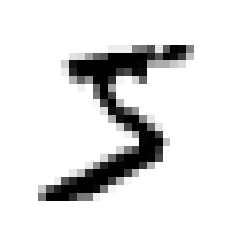

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit=x[0]
some_digit_image=some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap='binary')
plt.axis('off')
plt.show()

In [7]:
y[0]

'5'

In [8]:
import pandas as pd
pd.DataFrame(y).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       70000 non-null  object
dtypes: object(1)
memory usage: 547.0+ KB


In [9]:
y=y.astype(np.uint8)

In [10]:
pd.DataFrame(y).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       70000 non-null  uint8
dtypes: uint8(1)
memory usage: 68.5 KB


In [11]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [12]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    # 한 줄에 빈 공간을 픽셀값 0으로 채워주는 배열만드는 역할
    n_empty = n_rows * images_per_row - len(instances)
    # 빈 공간을 가져온 images 열에다가 붙여준다.
    images.append(np.zeros((size, size * n_empty)))
    # 반복문을 통해 각 
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")


그림 저장: more_digits_plot


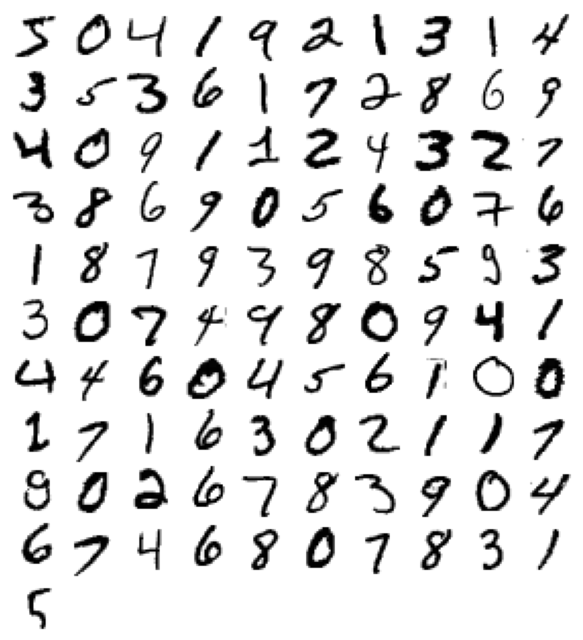

In [13]:
plt.figure(figsize=(9,9))
example_images = x[:101]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

원래 같았으면 train_test_split 같은 함수를 이용하여 셔플을 한 뒤 나눠주어야 하는데, 

사실 MNIST dataset은 훈련세트(앞의 60000개) 와 테스트세트(뒤의 10000개)를 나눠놓았다.

In [14]:
x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

## 이진 분류기 훈련

문제를 단순화해서 하나의 숫자, 5를 판별하는 문제로 바꿔보겠다.

따라서 각 레이블은 5가 양성클래스, 5를 제외한 숫자들은 음성클래스인 이진 분류 문제가 된다.

이진 분류 모형을 모델링 하는 방법으로 확률적 경사 하강법을 이용해서 학습해보겠다.

In [15]:
y_train_5=(y_train==5)
y_test_5=(y_train==5)

In [16]:
from sklearn.linear_model import SGDClassifier
sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(x_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [17]:
# 앞서 some_digit은 x[0] 인 값이다. 그 때의 값은 5
sgd_clf.predict([some_digit])

array([ True])

모형의 예측값도 똑같이 5로 예측하는 것을 알 수 있다.

y_train_5에서 5값은 True 나머진 False 이기 때문이다.

## 성능 측정

분류의 평가 방법은 여러가지가 존재한다. 사용할 수 있는 성능 지표들이 많다.
1. 교차 검증을 사용한 정확도 측정
2. 오차 행렬
3. 정밀도와 재현율
4. 정밀도/재현율 트레이드 오프 => PR 그래프
5. ROC 곡선

### 교차 검증을 사용한 정확도 측정

가끔 사이킷런이 제공하는 기능보다 교차검증 과정을 더 많이 제어해야 할 필요가 있다.

이때는 교차 검증 기능을 직접 구현하면 된다. 

다음 함수는 sklearn의 train_test_split과 거의 비슷한 성능을 낸다.

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# shuffle=False가 기본값이기 때문에 random_state를 삭제하던지 shuffle=True로 지정하라는 경고가 발생한다.
# 0.24버전부터는 에러가 발생할 예정이므로 향후 버전을 위해 shuffle=True을 지정한다.
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(x_train, y_train_5):
    clone_clf = clone(sgd_clf)
    x_train_folds = x_train[train_index]
    y_train_folds = y_train_5[train_index]
    x_test_fold = x_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [19]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,x_train,y_train_5,cv=3,scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

정확도가 모두 0.95를 넘어 아주 만족스러운 결과가 나왔다.

이번엔 모든 이미지를 5가 아닌 클래스로 분류하는 더미 분류기를 만들어 비교하겠다.

In [20]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, x, y=None):
        return self
    def predict(self, x):
        return np.zeros((len(x), 1), dtype=bool)

In [21]:
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf,x_train,y_train_5,cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

정확도가 90퍼 이상 나왔다. 이미지의 10% 정도가 숫자 5이기 때문에, 무조건 5아님으로 예측하는 비율이 90% 정도된다.

정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여준다.

특히 불균형한 데이터셋을 다룰 때(어떤 클래스가 다른 클래스보다 월등히 많은 경우)가 그렇다.

### 오차 행렬

분류기의 성능을 평가하는 더 좋은 방법은 **오차행렬** 을 나타내는 것이다.

오차 행렬의 행은 실제 클래스를 나타내고, 열은 예측 클래스를 나타낸다.

첫 번째 행은 음성클래스(5가 아님)을 나타내고 두 번째 행은 양성클래스(5)를 나타낸다.


In [22]:
from sklearn.model_selection import cross_val_predict
y_train_pred=cross_val_predict(sgd_clf,x_train,y_train_5,cv=3)

In [23]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [25]:
# 완벽한 분류기일 경우
y_train_perfect_predictions=y_train_5
confusion_matrix(y_train_5,y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

오차 행렬을 가지고 알아볼 수 있는 지표로는 정밀도와 재현율이 있다.

정밀도는 양성이라고 판단한 것 중에 실제 양성인 것의 비율을 의미하고

재현율은 실제 양성인 것 중에 양성이라고 판단한 비율이다.

흔히 재현율은 민감도라고도 하며, 분류기가 정확하게 정확하게 감지한 양성 샘플의 비율이다.

### 정밀도와 재현율 

sklearn은 정밀도와 재현율을 포함하여 분류기의 지표를 계산해주는 함수를 제공한다.

sklearn.metrics의 **precision_score**,**recall_score** 은 각각 정밀도와 재현율을 계산해주는 함수이다.



In [26]:
from sklearn.metrics import precision_score,recall_score
# 위에서한 오차 행렬에서 3530/(3530+687)
precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [27]:
# 위에서한 오차행렬에서 3530/(3530+1891)
recall_score(y_train_5,y_train_pred)

0.6511713705958311

정밀도와 재현율을 함께 사용하여 표현한 지표가 있다.

F1 Score라고 하는 하나의 숫자로 표현할 수 있는데, 이는 정밀도와 재현율의 조화 평균이다.

F1 Score 는 sklearn.metrics 의 **f1_score**이 제공한다.

In [28]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

정밀도와 재현율이 비슷한 분류기에서는 F1 Score 점수가 높다. 하지만 F1 Score 점수가 높다고 항상 바람직한 상황은 아니다.

상황에 따라 정밀도가 중요할 수도 있고, 재현율이 중요할 수도 있다.

정밀도와 재현율이 둘다 높은 것이 이상적인 분류기일수도 있지만,

정밀도와 재현율은 서로 tradeoff 관계에 있어서 둘 다 높은 점수를 얻기는 힘들다.

### 정밀도와 재현율의 트레이드 오프

SGDClassifier는 결정함수(Decision Function)을 사용하여 각 샘플의 점수를 계산한다.

이 점수가 임곗값보다 크면 양성 클래스에 할당하고, 작으면 음성 클래스에 할당한다.

사이킷런에서는 임곗값을 직접 지정할 수는 없지만, 예측에 사용한 점수는 확인할 수 있다.

분류기의 predict() 메소드 대신 decision_function() 메소드를 호출하면 각 샘플의 점수를 얻을 수 있다. 이 점수를 기반으로 원하는 임곗값을 정해 예측을 만들 수 있다.

In [29]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [30]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [31]:
y_some_digit_pred

array([ True])

In [32]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [33]:
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3,
                             method="decision_function")

In [34]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [35]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             

그림 저장: precision_recall_vs_threshold_plot


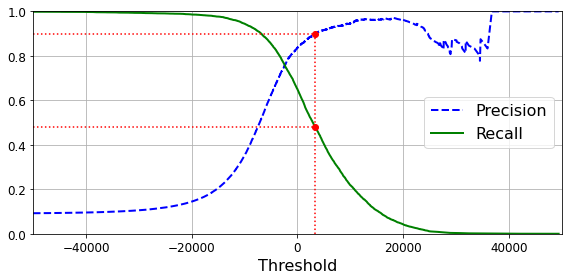

In [36]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
save_fig("precision_recall_vs_threshold_plot")                                              
plt.show()

In [37]:
(y_train_pred == (y_scores > 0)).all()

True

그림 저장: precision_vs_recall_plot


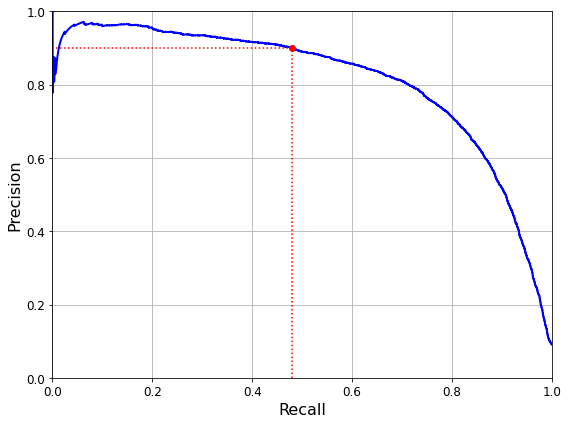

In [38]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [39]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [40]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [41]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [42]:
recall_score(y_train_5,y_train_pred_90)

0.4799852425751706

### ROC 곡선

ROC 곡선도 이진 분류에서 널리 사용하는 도구이다. 정밀도/재현율 곡선과 매우 비슷하지만,

ROC 곡선은 정밀도에 대한 재현율 곡선이 아니고, 거짓 양성 비율 (FPR) 에 대한 진짜 양성 비율 (TPR)의 곡선이다.

양성으로 잘못 분류된 음성 샘플의 비율이 FPR 이다.

이는 1에서 음성으로 정확하게 분류한 음성 샘플의 비율인 진짜 음성 비율(TNR)을 뺀값이다.

TNR을 특이도라고 하고, ROC 곡선은 민감도(재현율)에 대한 1-특이도 그래프이다.

ROC 곡선을 그리려면 먼저, roc_curve() 함수를 사용해 여러 임계값에서 TPR과 FPR을 계산해야한다.

In [43]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds=roc_curve(y_train_5,y_scores)

그림 저장: roc_curve_plot


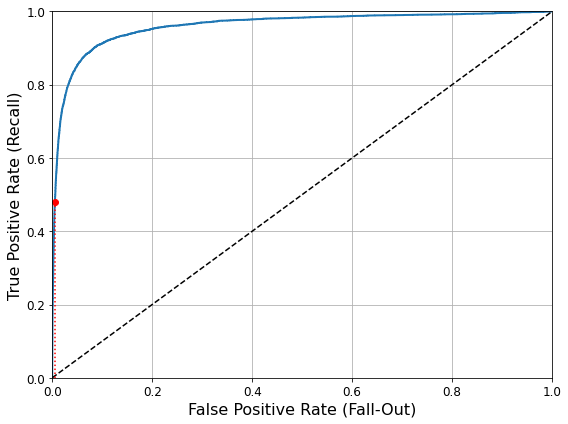

In [44]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
save_fig("roc_curve_plot")                                    
plt.show()

여기에서도 트레이드오프 관계가 있다. 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어난다. 점선은 완전한 랜덤 분류기의 ROC 곡선을 뜻한다.

좋은 분류기는 점선에서 최대한 멀리 떨어져 있어야한다.

곡선 아래의 면적(area under the curve) 을 측정하면 분류기들을 비교할 수 있다.

완벽한 분류기는 AUROC가 1이고, 완전한 랜덤분류기는 0.5이다.

In [45]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

ROC 곡선이 정밀도/재현율(PR) 곡선과 비슷해서 어떤 것을 사용해야 할지 의문이 든다.

일반적인 법칙은 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 PR 곡선을 사용하고 그렇지 않다면 ROC 곡선을 사용한다.

RandomForestClassifier를 훈련시켜 SGDClassifier의 ROC 곡선과 AUROC를 비교하겠다.

RandomForestClassifier에는 decision_function() 메소드가 없고, 대신 predict_proba() 메소드가 있다.

사이킷런의 분류기는 일반적으로 이 두 메소드 중 하나 또는 둘 모두를 가지고 있다.

predict_proba() 메소드는 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환한다.

In [46]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3,
                                    method="predict_proba")

In [47]:
y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

그림 저장: roc_curve_comparison_plot


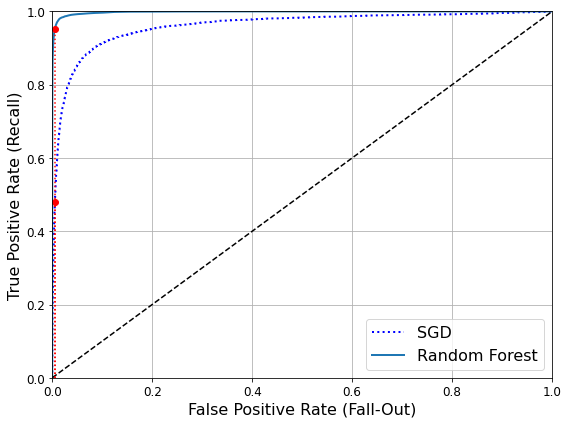

In [48]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [49]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [50]:
y_train_pred_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [51]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

## 다중 분류

이진 분류가 두 개의 클래스를 구별하는 반면 다중 분류기(다항 분류기)는 둘 이상의 클래스를 구별할 수 있다.

(SGD 분류기, 랜덤포레스트 분류기, 나이브 베이즈 분류기 같은) 일부 알고리즘은 여러 개의 클래스를 직접 처리할 수 있는 반면, (로지스틱 회귀, 서포트 벡터 머신 등과 같은) 다른 알고리즘은 이진 분류만 가능하다.

하지만 이진 분류기를 여러 개 사용해 다중 클래스를 분류하는 기법도 있다.

각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택하는데 이를 **OvR** 전략 또는 **OvA** 전략이라한다.

또 다른 전략은 0과 1구별, 0과 2구별, 1과 2구별 등과 같이 각 숫자의 조합마다 이진 분류기를 훈련시키는 것인데, 이런 전략을 **OvO** 전략이라고 한다.

클래스가 N개를 분류해야한다면, 분류기는 총 N(N-1)/2 개가 필요하다.

이미지 하나를 분류하려면 N(N-1)/2 개의 분류기 모두를 통과하여 가장 많이 양성으로 분류된 클래스를 선택한다.

OvO 전략의 주요 장점은 각 분류기의 훈련에 전체 훈려 세트 중 구별할 두 클래스에 해당하는 샘플만 필요하다.

(서포트 벡터 머신같은) 일부 알고리즘은 훈련 세트의 크기에 민감해서 큰 훈련 세트에서 몇 개의 분류기를 훈련시키는 것보다 작은 훈련 세트에서 많은 분류기를 훈련시키는 쪽이 빠르므로, OvO를 선호하지만, 대부분 이진 분류 알고리즘에서는 OvR을 선호한다.

다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 알고리즘에 따라 OvR 또는 OvO를 실행한다.

In [52]:
from sklearn.svm import SVC
svm_clf=SVC(gamma="auto", random_state=42)
svm_clf.fit(x_train[:1000],y_train[:1000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [53]:
some_digit_scores=svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [54]:
np.argmax(some_digit_scores)

5

In [55]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [56]:
svm_clf.classes_[5]

5

서포트 벡터 머신은 내부적으로 OvO 전략을 사용해 45개의 이진 분류기를 훈련시키고, 각각의 결정 점수를 얻어 점수가 가장 높은 클래스를 선택한다.

사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 OneVsOneClassifier나 OneVsRestClassifier를 사용한다.

In [57]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf=OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(x_train[:500],y_train[:500])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [58]:
len(ovr_clf.estimators_)

10

SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도로 sklearn의 OvR이나 OvO를 적용할 필요가 없다.

In [59]:
sgd_clf.fit(x_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [60]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [61]:
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [62]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 에러 분석

데이터 준비 단계에서 가능한 선택 사항을 탐색하고, 여러 모델을 시도하고, 가장 좋은 몇 개를 골라 하이퍼파라미터를 튜닝하고 자동화를 할 것이다.

이 후 모델의 성능을 향상시키기 위해 에러의 종류를 분석하는 활동을 한다.

In [63]:
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

많은 숫자가 출력되는데, 이 오차 행렬을 matplotlib의 matshow() 함수를 사용해 이미지로 표현할 수 있다.

그림 저장: confusion_matrix_plot


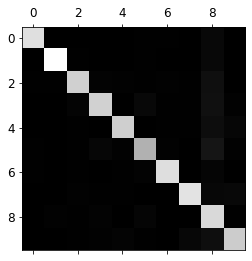

In [64]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

이 오차 행렬은 대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있으므로 좋아보인다. 숫자 5는 다른 숫자보다 조금 더 어두워 보인다.

이는 데이터셋에 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻이다.

그래프의 에러 부분에 초점을 맞추겠다. 

먼저 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 비교한다.

다른 항목은 그대로 유지하고, 주대각선만 0으로 채워서 그래프를 그린다.

In [65]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

그림 저장: confusion_matrix_errors_plot


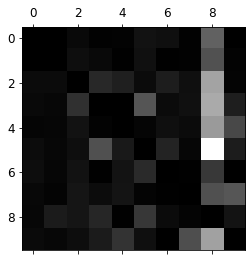

In [66]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

행은 실제 클래스를 나타내고, 열은 예측 클래스를 나타낸다.

클래스 8의 열이 전체적으로 밝으면서 많은 이미지가 8로 잘못 분류 되었음을 알 수 있다.

성능 향상을 위해 후에 동심원의 개수를 세는 알고리즘이나, 동심원 같은 어떤 패턴이 드러나도록 이미지 전처리를 해서 성능을 올릴 수 있다.

개개의 에러를 분석해보면 분류기가 무슨 일을 하고, 왜 잘못되었는지에 대해 통찰을 얻을 수 있다.

예를 들어 3과 5의 샘플을 그려보겠다. (plot_digits()는 matplotlib의 imshow()함수를 사용하는 함수이다.)

그림 저장: error_analysis_digits_plot


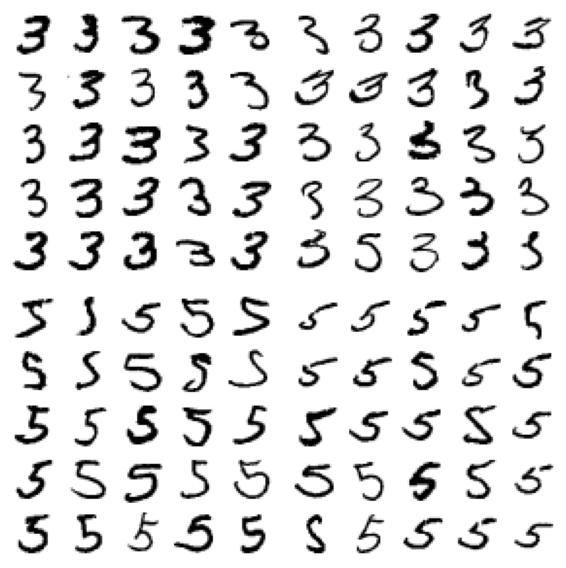

In [67]:
cl_a, cl_b = 3, 5
x_aa = x_train[(y_train == cl_a) & (y_train_pred == cl_a)]
x_ab = x_train[(y_train == cl_a) & (y_train_pred == cl_b)]
x_ba = x_train[(y_train == cl_b) & (y_train_pred == cl_a)]
x_bb = x_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(x_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(x_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(x_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(x_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

왼쪽의 5x5 블록 두 개는 3으로 분류된 이미지이고, 오른쪽 5x5 블록 두개는 5로 분류된 이미지다.

대부분의 잘못 분류된 이미지는 확실히 에러인 것 같고 분류기가 실수한 이유를 이해하기 어렵다.

원인은 선형 모델인 SGDClassifier를 사용했기 때문인데, 클래스마다 픽셀의 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산하기 때문에, 3과 5는 몇 개의 픽셀만 달라서 모델이 혼동하기에 쉽다.

이를 보완하기 위해 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리 해주는 것이다.

## 다중 레이블 분석

지금까지는 각 샘플이 하나의 클래스에만 할당되었다. 하지만 분류기가 샘플마다 여러 개의 클래스를 출력해야 할 때도 있다.

학습을 위해 타깃값을 2개로 만들어 진행해보겠다.

In [69]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

위 코드는 각 숫자 이미지에 두 개의 타깃 레이블이 담긴 배열을 만든다.

첫 번째는 숫자가 7,8,9인지를 판별하고, 두 번째는 홀수인지 나타낸다.

KneighborsClassifier는 다중 레이블 분류를 지원하지만 모든 분류기가 지원하는 것은 아니다.


In [70]:
knn_clf.predict([some_digit])

array([[False,  True]])

some_digit이 5 였기 때문에 위에 결과가 맞게 나온 것을 확인할 수 있다.

다중 레이블 분류기를 평가하는 방법은 많다. 적절한 지표는 프로젝트에 따라 다르다.

여기에서는 각 레이블의 F1 점수를 구하고 평균을 내어 계산한다.

In [73]:
y_train_knn_pred = cross_val_predict(knn_clf, x_train[:500], y_multilabel[:500], cv=3)
f1_score(y_multilabel[:500], y_train_knn_pred[:500], average="macro")

0.8858707973603104

실제로는 아닐 수 있지만, 이 코드는 모든 레이블의 가중치가 같다고 가정한 것이다.

레이블에 클래스의 지지도를 가중치로 주어 계산할 수 있는데 이렇게 하라면 average='weight'로 설정하면 된다.

## 다중 출력 분석

다중 출력 다중 클래스 분류는 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화 한 것이다.

이를 위해 이미지에서 잡음을 제거하는 시스템을 만들어보겠다.

잡음이 많은 숫자 이미지를 입력으로 받고, 깨끗한 숫자 이미지를 MNIST 이미지처럼 픽셀의 강도를 담은 배열로 출력한다. 

분류기의 출력이 다중 레이블이고 각 레이블은 값을 여러개 가진다. 

In [74]:
noise = np.random.randint(0, 100, (len(x_train), 784))
x_train_mod = x_train + noise
noise = np.random.randint(0, 100, (len(x_test), 784))
x_test_mod = x_test + noise
y_train_mod = x_train
y_test_mod = x_test

그림 저장: noisy_digit_example_plot


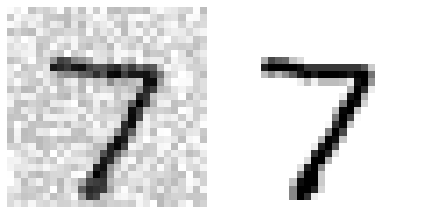

In [75]:
some_index = 0
plt.subplot(121); plot_digit(x_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

그림 저장: cleaned_digit_example_plot


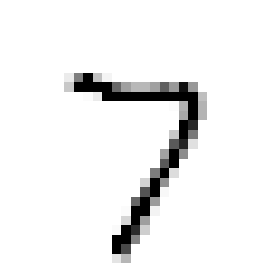

In [78]:
knn_clf.fit(x_train_mod, y_train_mod)
clean_digit = knn_clf.predict([x_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")